We will try to predict top 3 scores here

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [2]:
data = pd.read_csv("../data/merged_data.csv")

In [3]:
data.dropna(axis=0,subset=["%"],inplace=True)
data = data[data["Rang"] <= 3]
data.reset_index(drop=True,inplace=True)

# Encoding categorical variables

In [4]:
X = data[['Nation', 'Pos', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY', 'CrdR','winner_Bundesliga',
       'winner_C3', 'finalist_C3', 'winner_UCL', 'finalist_UCL',
       'winner_Club WC', 'finalist_Club WC', 'winner_Copa America',
       'finalist_Copa America', 'winner_Euro', 'finalist_Euro', 'winner_Liga',
       'winner_Ligue 1', 'winner_PL', 'winner_Serie A', 'winner_WC',
       'finalist_WC']]
y = data[['%']].astype(float)

In [5]:
import sklearn.preprocessing

encoder = sklearn.preprocessing.OrdinalEncoder()
X['Pos'] = encoder.fit_transform(X[['Pos']])
X['Nation'] = encoder.fit_transform(X[['Nation']])

## Train test split

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Preprocessing

Imputing missing values

In [7]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3, weights="uniform")
X_train = pd.DataFrame(imputer.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(imputer.fit_transform(X_test),columns=X_test.columns)

Data Augmentation

In [8]:
def noise(X, y, n, sigma):
    _X = X.copy()
    _y = y.copy()
    for _ in range(n):
        X = np.r_[X, _X + np.random.randn(*_X.shape)*sigma]
        y = np.r_[y, _y]
    return X, y

In [9]:
X_train_augmented, y_train_augmented = noise(X_train, y_train,60, 2)
X_train_augmented = pd.DataFrame(X_train_augmented,columns=X_train.columns)
y_train_augmented = pd.DataFrame(y_train_augmented,columns=y_train.columns)

In [62]:
X_train_augmented.shape

(2501, 25)

Standardisation

In [10]:
X_train_standardized = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(X_train),columns=X_train.columns)
X_train_augmented_standardized = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(X_train_augmented),columns=X_train.columns)

# Model building

In [17]:
from sklearn.model_selection import learning_curve

def print_learning_curve(model,X=X_train_augmented_standardized,y=y_train_augmented,score='neg_root_mean_squared_error'):
    N, train_score, val_score = learning_curve(model, X,y, train_sizes=np.linspace(0.1,1,10),cv=10,scoring=score)
    plt.plot(N[1:], abs(train_score.mean(axis=1))[1:],label="train")
    plt.plot(N[1:], abs(val_score.mean(axis=1))[1:], label="validation")
    plt.xlabel('train_sizes')
    plt.legend()

    mean_train_score = abs(train_score.mean(axis=1))[9]
    mean_val_score = abs(val_score.mean(axis=1))[9]

    train_percent_of_mean = mean_train_score * 100 / y['%'].mean()
    val_percent_of_mean = mean_val_score *100 / y['%'].mean()

    # train_percent_of_std = abs(mean_train_score-y.std()) * 100 / y.std()
    # val_percent_of_mean = mean_val_score * 100 / y.std()

    print("Training RMSE : "+str(mean_train_score)+ " ("+str(train_percent_of_mean)+"% of the mean)")
    print("Validation RMSE : "+str(mean_val_score)+ " ("+str(val_percent_of_mean)+"% of the mean)")

In [45]:
y_train_augmented.std()

8.389949739771268

## Linear regression

Training RMSE : 7.074858001812947 (33.2140358986255% of the mean)
Validation RMSE : 7.1308269882627 (33.47679112631705% of the mean)


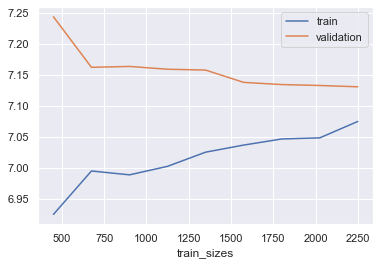

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve

print_learning_curve(LinearRegression())

## Ridge Regression

In [74]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

ridge = RidgeCV(alphas = np.linspace(10,500),cv=10,scoring='neg_root_mean_squared_error').fit(X_train_augmented_standardized,y_train_augmented)
print(ridge.alpha_)

110.0


Training RMSE : 7.124197229945077 (33.44566668103429% of the mean)
Validation RMSE : 7.186906732583951 (33.74006632429197% of the mean)


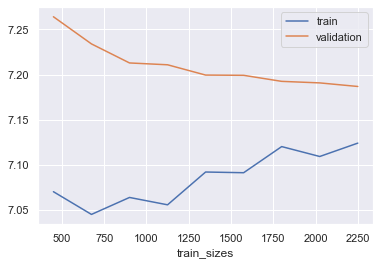

In [75]:
print_learning_curve(Ridge(alpha=110.0))

## Lasso Regression

In [76]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

lasso = LassoCV(alphas = np.linspace(-5,5),cv=10).fit(X_train_augmented_standardized,y_train_augmented)
print(lasso.alpha_)

0.1020408163265305


Training RMSE : 7.137271638103682 (33.50704655068283% of the mean)
Validation RMSE : 7.183189909245698 (33.72261711135315% of the mean)


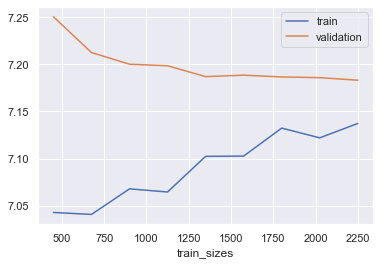

In [77]:
print_learning_curve(Lasso(alpha=0.1020408163265305))

<AxesSubplot:>

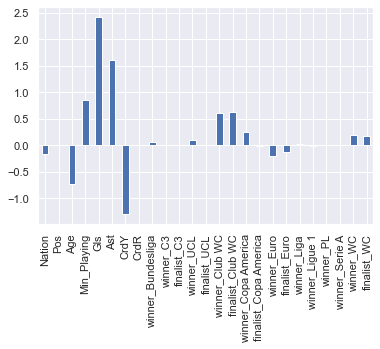

In [78]:
lasso_coef = pd.Series(lasso.coef_,index=X.columns)

lasso_coef.plot.bar()

## Polynomial regression

Training RMSE : 5.337263064039449 (25.056622615462793% of the mean)
Validation RMSE : 6.244953526478934 (29.31791854487643% of the mean)


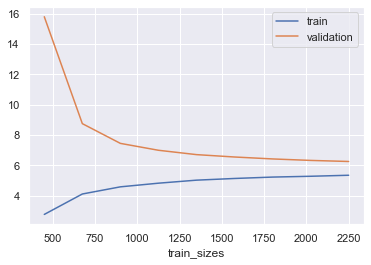

In [83]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_augmented_standardized)

print_learning_curve(LinearRegression(),X=X_train_poly)

Training RMSE : 1.481678802137854e-13 (6.95597465162245e-13% of the mean)
Validation RMSE : 19.250168334752523 (90.37294910529833% of the mean)


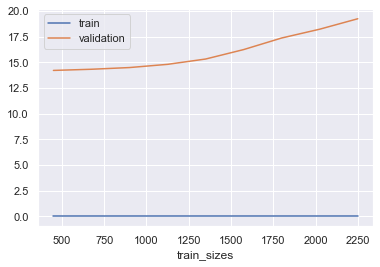

In [84]:
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train_augmented_standardized)

print_learning_curve(LinearRegression(),X=X_train_poly)

degree 2 : 6.13 -> 29% RMSE (validation)
 
degree 3 : 21.75 -> 102% RMSE (validation)

trying regularisation on R_3[X] regression

Training RMSE : 4.575296534743906 (21.479450656521983% of the mean)
Validation RMSE : 6.419514291223917 (30.13742156603186% of the mean)


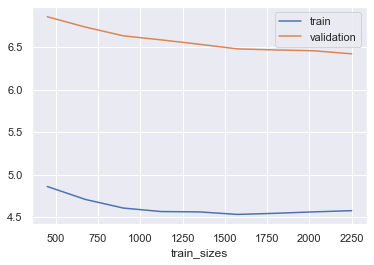

In [88]:
print_learning_curve(Ridge(alpha=5000),X_train_poly,y_train_augmented)

In [82]:
for a in tqdm(range(10,20)):
    print(a/100,cross_val_score(Lasso(a/100),X_train_poly,y_train_augmented,cv=10,scoring="neg_root_mean_squared_error").mean())

 10%|█         | 1/10 [00:22<03:25, 22.82s/it]

0.1 -6.092883944447353


 20%|██        | 2/10 [00:45<03:03, 22.92s/it]

0.11 -6.06838156775619


 30%|███       | 3/10 [01:08<02:39, 22.74s/it]

0.12 -6.057276093601635


 40%|████      | 4/10 [01:28<02:10, 21.67s/it]

0.13 -6.048922656751091


 50%|█████     | 5/10 [01:47<01:44, 20.92s/it]

0.14 -6.041037967836862


 60%|██████    | 6/10 [02:04<01:18, 19.57s/it]

0.15 -6.033719359816638


 70%|███████   | 7/10 [02:20<00:54, 18.25s/it]

0.16 -6.0257647091956015


 80%|████████  | 8/10 [02:34<00:34, 17.00s/it]

0.17 -6.020902261572067


 90%|█████████ | 9/10 [02:49<00:16, 16.35s/it]

0.18 -6.019551397755166


100%|██████████| 10/10 [03:02<00:00, 18.26s/it]

0.19 -6.020863817971984


Training RMSE : 5.063025600511506 (23.769171622661094% of the mean)
Validation RMSE : 5.961119748709281 (27.985416142472317% of the mean)


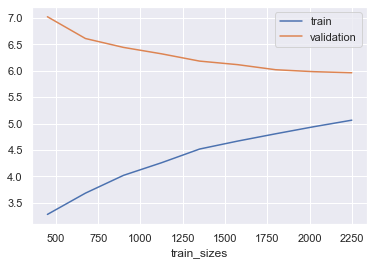

In [85]:
print_learning_curve(Lasso(alpha=0.18),X_train_poly,y_train_augmented)

Non linear methods

Training RMSE : 6.345665143112756 (29.7907251014783% of the mean)
Validation RMSE : 6.962407733756467 (32.68612039288942% of the mean)


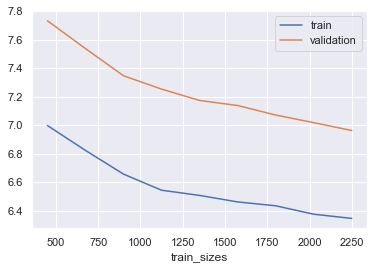

In [91]:
from sklearn.svm import SVR

print_learning_curve(SVR(C=2))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[500,1000],
                'min_samples_leaf':[4,5,6],
                'max_features':["sqrt",X_train.shape[0]/3]}

grid = GridSearchCV(RandomForestRegressor(),parameters).fit(X_train_augmented,y_train_augmented)

In [95]:
grid.best_estimator_

RandomForestRegressor(max_features='sqrt', min_samples_leaf=4, n_estimators=500)

Training RMSE : 2.3668186027733826 (11.111402945176481% of the mean)
Validation RMSE : 3.8597859042045166 (18.12037323581706% of the mean)


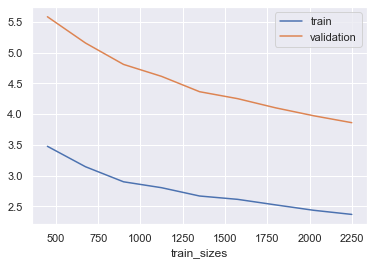

In [96]:
print_learning_curve(RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      n_estimators=500,random_state=0))

<AxesSubplot:>

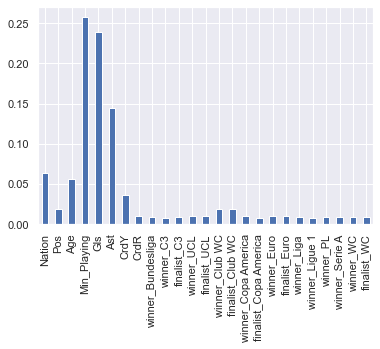

In [97]:
importances = grid.best_estimator_.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

forest_importances.plot.bar()

In [98]:
parameters = {'min_samples_leaf':[2,3,4],
                'max_depth':[4,5,6,7,8,9,None],'n_estimators':[500]}

grid = GridSearchCV(RandomForestRegressor(),parameters).fit(X_train_augmented,y_train_augmented)

In [99]:
grid.best_estimator_

RandomForestRegressor(max_depth=9, min_samples_leaf=2, n_estimators=500)

In [100]:
parameters = {'min_samples_leaf':[2],
                'max_depth':[9,None],'n_estimators':[500]}

grid = GridSearchCV(RandomForestRegressor(),parameters).fit(X_train_augmented,y_train_augmented)

In [101]:
grid.best_estimator_

RandomForestRegressor(min_samples_leaf=2, n_estimators=500)

Training RMSE : 1.694992337585053 (7.957408662339052% of the mean)
Validation RMSE : 3.578112923913224 (16.798015037720297% of the mean)


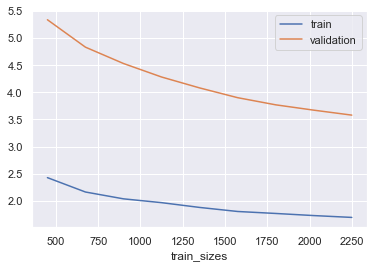

In [15]:
print_learning_curve(RandomForestRegressor(max_features='sqrt', min_samples_leaf=2, max_depth=None,
                      n_estimators=500,random_state=0))

Trying to regularize by using only most important features

Training RMSE : 1.0596222149164236 (4.974563486107642% of the mean)
Validation RMSE : 1.9981727439668215 (9.380736861822845% of the mean)


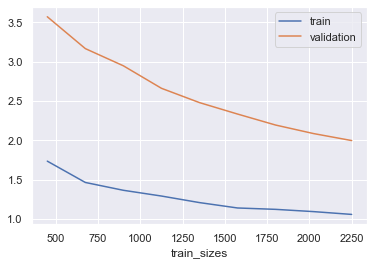

In [17]:
print_learning_curve(RandomForestRegressor(max_features='sqrt', min_samples_leaf=2, max_depth=None,
                      n_estimators=500,random_state=0),X=X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']])

In [18]:
parameters = {'min_samples_leaf':[2,3,4,5,6],
                'max_depth':[4,5,6,7,8,9],'n_estimators':[500,100],
                'max_features':["sqrt",X_train.shape[0]/3]}

grid = GridSearchCV(RandomForestRegressor(),parameters).fit(X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']],y_train_augmented)

In [19]:
grid.best_estimator_

RandomForestRegressor(max_depth=9, max_features='sqrt', min_samples_leaf=2)

In [20]:
parameters = {'n_estimators':[500,1000,5000]}

grid = GridSearchCV(RandomForestRegressor(),parameters).fit(X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']],y_train_augmented)

Training RMSE : 1.5064768360766897e-14 (7.072392930158748e-14% of the mean)
Validation RMSE : 2.4172473818692213 (11.348148796299407% of the mean)


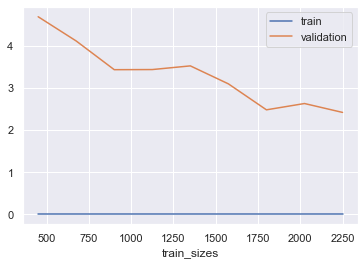

In [39]:
from sklearn import tree

print_learning_curve(tree.DecisionTreeRegressor(),X_train_augmented)

[Text(208.223473083249, 213.69103448275862, 'X[4] <= 28.089\nsquared_error = 70.391\nsamples = 2501\nvalue = 21.301'),
 Text(101.13176398026316, 206.19310344827585, 'X[3] <= 2535.208\nsquared_error = 38.572\nsamples = 1999\nvalue = 19.22'),
 Text(45.408097165991904, 198.6951724137931, 'X[3] <= 2354.463\nsquared_error = 18.831\nsamples = 898\nvalue = 17.0'),
 Text(21.68744939271255, 191.19724137931036, 'X[3] <= 1733.647\nsquared_error = 16.09\nsamples = 599\nvalue = 18.403'),
 Text(12.538056680161944, 183.69931034482758, 'X[3] <= 1647.947\nsquared_error = 21.96\nsamples = 244\nvalue = 16.188'),
 Text(8.810526315789474, 176.20137931034483, 'X[4] <= 4.437\nsquared_error = 5.599\nsamples = 183\nvalue = 18.622'),
 Text(5.421862348178138, 168.70344827586206, 'X[3] <= 1140.389\nsquared_error = 2.039\nsamples = 126\nvalue = 17.244'),
 Text(2.710931174089069, 161.2055172413793, 'X[3] <= 436.562\nsquared_error = 0.654\nsamples = 65\nvalue = 18.508'),
 Text(1.3554655870445345, 153.70758620689656,

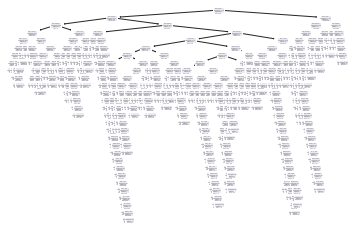

In [40]:
tree.plot_tree(tree.DecisionTreeRegressor().fit(X_train_augmented,y_train_augmented))

Training RMSE : 1.489993749566569e-14 (6.995010482775774e-14% of the mean)
Validation RMSE : 2.149230328387853 (10.089900498808085% of the mean)


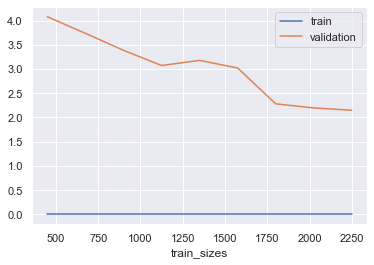

In [42]:
print_learning_curve(tree.DecisionTreeRegressor(),X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']])

[Text(209.2860202595339, 213.69103448275862, 'X[4] <= 28.089\nsquared_error = 70.391\nsamples = 2501\nvalue = 21.301'),
 Text(104.6083752648305, 206.19310344827585, 'X[3] <= 2535.208\nsquared_error = 38.572\nsamples = 1999\nvalue = 19.22'),
 Text(48.23389830508474, 198.6951724137931, 'X[3] <= 2354.463\nsquared_error = 18.831\nsamples = 898\nvalue = 17.0'),
 Text(22.698305084745762, 191.19724137931036, 'X[3] <= 1733.647\nsquared_error = 16.09\nsamples = 599\nvalue = 18.403'),
 Text(13.122457627118644, 183.69931034482758, 'X[3] <= 1647.947\nsquared_error = 21.96\nsamples = 244\nvalue = 16.188'),
 Text(9.221186440677966, 176.20137931034483, 'X[4] <= 4.437\nsquared_error = 5.599\nsamples = 183\nvalue = 18.622'),
 Text(5.6745762711864405, 168.70344827586206, 'X[3] <= 1140.389\nsquared_error = 2.039\nsamples = 126\nvalue = 17.244'),
 Text(2.8372881355932202, 161.2055172413793, 'X[3] <= 436.562\nsquared_error = 0.654\nsamples = 65\nvalue = 18.508'),
 Text(1.4186440677966101, 153.7075862068965

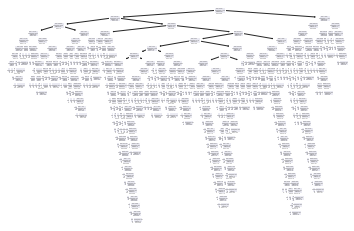

In [43]:
tree.plot_tree(tree.DecisionTreeRegressor().fit(X_train_augmented,y_train_augmented))

In [48]:
parameters = {'splitter':('best','random'),'max_depth':[9,10,11,12,13,14],'max_features':["auto","sqrt","log2"]}

grid = GridSearchCV(tree.DecisionTreeRegressor(),parameters).fit(X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']],y_train_augmented)

In [49]:
grid.best_estimator_

DecisionTreeRegressor(max_depth=14, max_features='auto')

Training RMSE : 0.10171408195361134 (0.477512788035785% of the mean)
Validation RMSE : 2.1056331598405427 (9.885226720078146% of the mean)


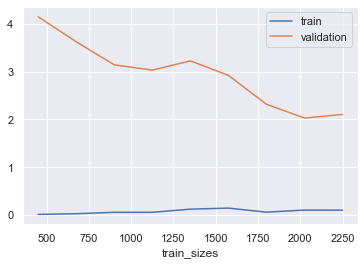

In [54]:
print_learning_curve(tree.DecisionTreeRegressor(max_depth=12,splitter='best'),X_train_augmented[['Nation', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY']])

In [12]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

parameters = {'learning_rate':np.linspace(0.01,0.3),'max_iter':[10000],'max_depth':np.arange(3,12,1),'max_leaf_nodes':np.arange(20,3000,50)}

random_search = RandomizedSearchCV(HistGradientBoostingRegressor(),parameters,n_jobs=-1)

In [13]:
random_search = random_search.fit(X_train_augmented,y_train_augmented)

In [14]:
random_search.best_estimator_

HistGradientBoostingRegressor(learning_rate=0.04551020408163265, max_depth=8,
                              max_iter=10000, max_leaf_nodes=2020)

Training RMSE : 2.2758556993188942e-05 (0.00010684363259008026% of the mean)
Validation RMSE : 2.1889435718940393 (10.27634057931957% of the mean)


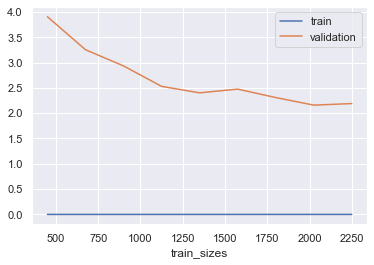

In [18]:
print_learning_curve(HistGradientBoostingRegressor(learning_rate=0.04551020408163265, max_depth=8,
                              max_iter=10000, max_leaf_nodes=256))

In [21]:
model = HistGradientBoostingRegressor(learning_rate=0.04551020408163265, max_depth=8,
                              max_iter=10000, max_leaf_nodes=256,l2_regularization=2).fit(X_train_augmented,y_train_augmented)

categorical_features=[True,True,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True]

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

parameters = {'l2_regularization':np.linspace(0,100),"min_samples_leaf":np.linspace(0,20)}

grid = RandomizedSearchCV(HistGradientBoostingRegressor(learning_rate=0.04551020408163265, max_depth=8,
                              max_iter=10000, max_leaf_nodes=256),parameters,n_jobs=-1)

In [44]:
grid = grid.fit(X_train_augmented,y_train_augmented)

In [45]:
grid.best_estimator_

HistGradientBoostingRegressor(l2_regularization=32.6530612244898,
                              learning_rate=0.04551020408163265, max_depth=8,
                              max_iter=10000, max_leaf_nodes=256,
                              min_samples_leaf=4.081632653061225)

In [52]:
from sklearn.metrics import mean_squared_error

(mean_squared_error(y_train,grid.best_estimator_.predict(X_train)))

7.4098773022296146e-06

In [47]:
cross_val_score(HistGradientBoostingRegressor(l2_regularization=32.6530612244898,
                              learning_rate=0.04551020408163265, max_depth=8,
                              max_iter=10000, max_leaf_nodes=256,
                              min_samples_leaf=4.081632653061225),X_train_augmented,y_train_augmented,cv=10,n_jobs=-1,scoring="neg_root_mean_squared_error").mean()

-1.8438636119693839